In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Daten laden
df = pd.read_csv('../data/raw/OnlineRetail.csv', encoding='ISO-8859-1')
print("Datensatz Übersicht:")
print(f"Shape: {df.shape}")
print("\nErste Zeile:")
df.head()

Datensatz Übersicht:
Shape: (541909, 8)

Erste Zeile:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [24]:
print("\nDatentypen:")
print(df.dtypes)
print("\nFehlende Werte:")
print(df.isnull().sum())
print("\nStatistische Einblick:")
print(df.describe())


Datentypen:
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Fehlende Werte:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Statistische Einblick:
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


In [5]:
# Datenbereinigung 
print("\nDatenbereinigung startet....")

# Fehlende CustomerID entfernen
df_clean = df[df['CustomerID'].notna()].copy()
print(f"Nach Entfernung fehlender CustomerID: {df_clean.shape[0]} Zeilen")

# Negative Mengen und Preise entfernen(Retouren)
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]
print(f"Nach Entfernung negativer Werte: {df_clean.shape[0]} Zeilen")

# IvoiceDate in Datetime konvertieren
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Gesamtbetrag berechnen
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']

print("\nDatenbereinigung abgeschlossen!")
print(f"Finale Daten: {df_clean.shape}")
print(f"Anzahl Kunden: {df_clean['CustomerID'].nunique()}")



Datenbereinigung startet....
Nach Entfernung fehlender CustomerID: 406829 Zeilen
Nach Entfernung negativer Werte: 397884 Zeilen

Datenbereinigung abgeschlossen!
Finale Daten: (397884, 9)
Anzahl Kunden: 4338


In [6]:
# RFM-Analyse erstellen
print("Feature Engineering: RFM-Analyse")
print("=" * 50)

#Referenzdatum festlegen
snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Referenzdatum: {snapshot_date}")

# RFM pro Kunde berechnen
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).reset_index()

# Spalten umbenennen
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Ergebnisse
print(f"\nRFM-Features erstellt für {len(rfm)} Kunden")
print("\nErste 10 Kunden:")
print(rfm.head(10))

print("\nRFM Statistiken:")
print(rfm.describe())


Feature Engineering: RFM-Analyse
Referenzdatum: 2011-12-10 12:50:00

RFM-Features erstellt für 4338 Kunden

Erste 10 Kunden:
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40
5     12352.0       36          8   2506.04
6     12353.0      204          1     89.00
7     12354.0      232          1   1079.40
8     12355.0      214          1    459.40
9     12356.0       23          3   2811.43

RFM Statistiken:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    

In [7]:
# Prüfen auf problematische Werte
print("\nDatenqualität Checken:")
print(f"Fehlende Werte: {rfm.isnull().sum().sum()}")
print(f"Negative Werte in Recency: {(rfm['Recency'] < 0).sum()}")
print(f"Null-Werte in Frequency: {(rfm['Frequency'] == 0).sum()}")
print(f"Null-Werte in Monetary: {(rfm['Monetary'] <= 0).sum()}")


Datenqualität Checken:
Fehlende Werte: 0
Negative Werte in Recency: 0
Null-Werte in Frequency: 0
Null-Werte in Monetary: 0


Explorative Datenanalyse (EDA)


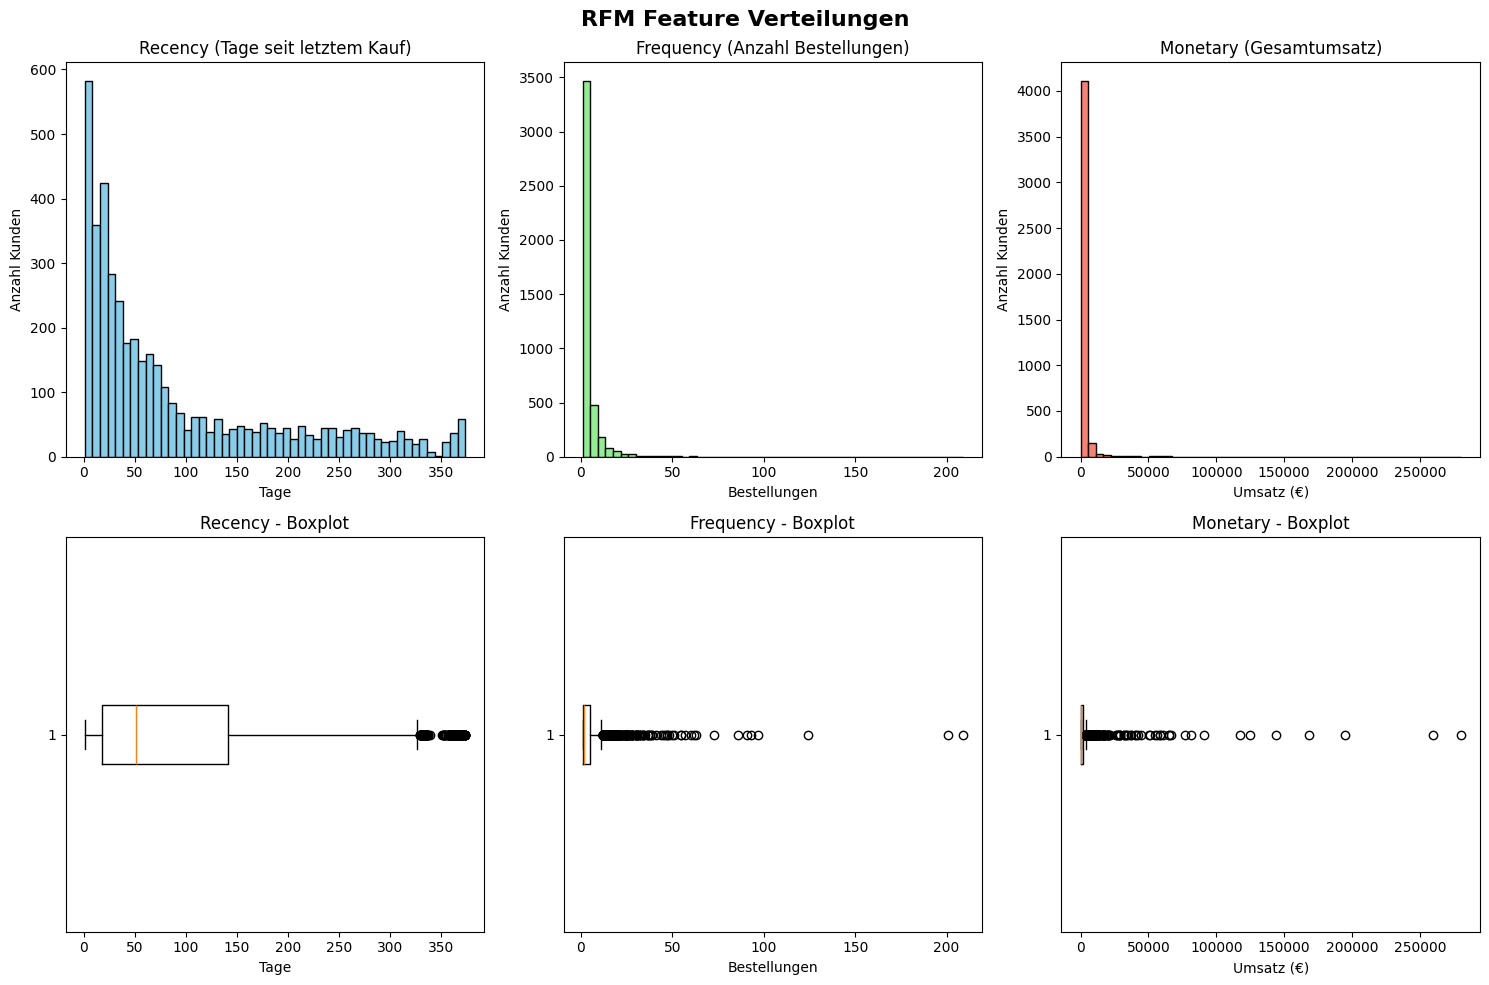

In [8]:
# EDA: Verteilungen visualisieren
print("Explorative Datenanalyse (EDA)")
print("="*60)

# Figure mit Subplots erstellen
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('RFM Feature Verteilungen', fontsize=16, fontweight='bold')

axes[0, 0].hist(rfm['Recency'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Recency (Tage seit letztem Kauf)')
axes[0, 0].set_xlabel('Tage')
axes[0, 0].set_ylabel('Anzahl Kunden')

axes[0, 1].hist(rfm['Frequency'], bins=50, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Frequency (Anzahl Bestellungen)')
axes[0, 1].set_xlabel('Bestellungen')
axes[0, 1].set_ylabel('Anzahl Kunden')

axes[0, 2].hist(rfm['Monetary'], bins=50, color='salmon', edgecolor='black')
axes[0, 2].set_title('Monetary (Gesamtumsatz)')
axes[0, 2].set_xlabel('Umsatz (€)')
axes[0, 2].set_ylabel('Anzahl Kunden')

axes[1, 0].boxplot(rfm['Recency'], vert=False)
axes[1, 0].set_title('Recency - Boxplot')
axes[1, 0].set_xlabel('Tage')

axes[1, 1].boxplot(rfm['Frequency'], vert=False)
axes[1, 1].set_title('Frequency - Boxplot')
axes[1, 1].set_xlabel('Bestellungen')

axes[1, 2].boxplot(rfm['Monetary'], vert=False)
axes[1, 2].set_title('Monetary - Boxplot')
axes[1, 2].set_xlabel('Umsatz (€)')

plt.tight_layout()
plt.show()



In [9]:
print("="*50)
print("Statistische Kennzahlen für Ausreißer")
print("="*50)
print("\nAusreißer-Analyse:")
print("\nRecency:")
print(f" - 95% der Kunden: <= {rfm['Recency'].quantile(0.95):.0f} Tage")
print(f" - Maximum: {rfm['Recency'].max():.0f} Tage")

print("\nFrequency:")
print(f" - 95% der Kunden: <= {rfm['Frequency'].quantile(0.95):.0f} Bestellungen")
print(f" - Maximum: {rfm['Frequency'].max():.0f} Bestellungen")

print("\nMonetary:")
print(f" - 95% der Kunden: <= {rfm['Monetary'].quantile(0.95):.2f}€")
print(f" - Maximum: {rfm['Monetary'].max():.2f}€")

print("\nErkenntnis: Die Daten sind stark rechtsschief!")
print(" -> Wir brauchen Log-Transformation + Skalierung!")

Statistische Kennzahlen für Ausreißer

Ausreißer-Analyse:

Recency:
 - 95% der Kunden: <= 312 Tage
 - Maximum: 374 Tage

Frequency:
 - 95% der Kunden: <= 13 Bestellungen
 - Maximum: 209 Bestellungen

Monetary:
 - 95% der Kunden: <= 5841.84€
 - Maximum: 280206.02€

Erkenntnis: Die Daten sind stark rechtsschief!
 -> Wir brauchen Log-Transformation + Skalierung!


Transformation & Skalierung
Schritt 1: Log-Transformation(Log1p)
----------------------------------------
Original vs. Log-transformiert:

Original:
           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272015    2054.266460
std     100.014169     7.697998    8989.230441
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     307.415000
50%      51.000000     2.000000     674.485000
75%     142.000000     5.000000    1661.740000
max     374.000000   209.000000  280206.020000

Nach Log-Transformation:
           Recency    Frequency     Monetary
count  4338.000000  4338.000000  4338.000000
mean      3.830734     1.345582     6.593627
std       1.340261     0.683104     1.257578
min       0.693147     0.693147     1.558145
25%       2.944439     0.693147     5.731446
50%       3.951244     1.098612     6.515431
75%       4.962845     1.791759     7.416222
max       5.926926     5.347108    12.5432

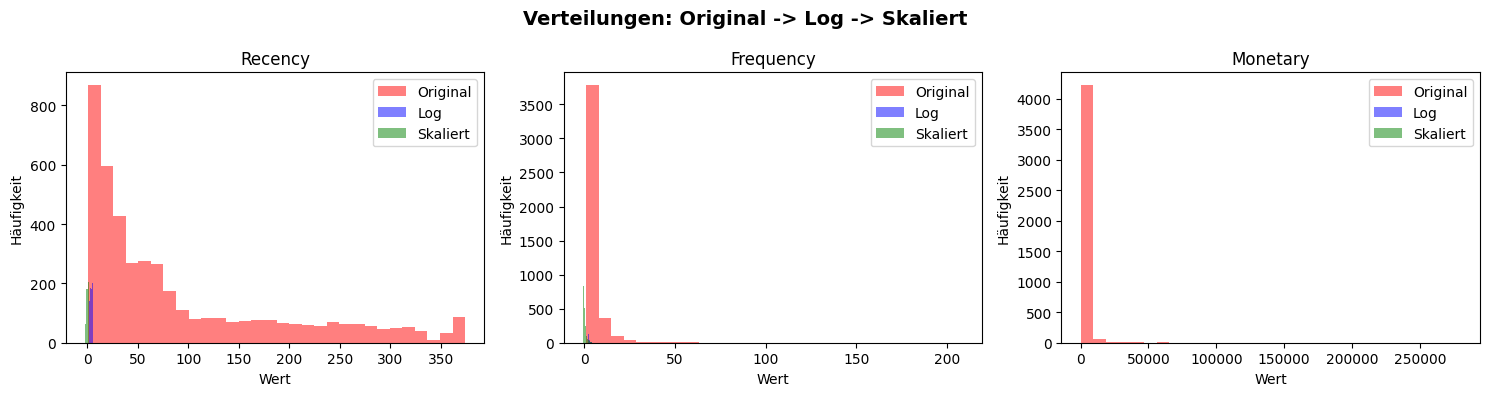


PHASE 1 Abgeschlossen!
Bereite Daten: (4338, 3)
 -> Bereit für K-Means Clustering!


In [10]:
# Transfomation & Salierung
print("Transformation & Skalierung")
print("="*50)

# Vorbereitung: Features extrahieren
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']].copy()

print("Schritt 1: Log-Transformation(Log1p)")
print("-" * 40)
rfm_log = np.log1p(rfm_features)

print("Original vs. Log-transformiert:")
print("\nOriginal:")
print(rfm_features.describe())
print("\nNach Log-Transformation:")
print(rfm_log.describe())

print("\n" + "="*50)
print("Schritt 2: StandardScaler anwenden")
print("-" * 40)

# StandardScaler: (x - mean) / std -> Mittelwert=0, Standardabweichung=1
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# Als DataFrame für bessere Übersicht
rfm_scaled_df = pd.DataFrame(
    rfm_scaled,
    columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']
)
print("Nach Skalierung (sollte ~0 mean, ~1 std haben):")
print(rfm_scaled_df.describe())

# Visualisierung: Vorher vs. Nachher
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Verteilungen: Original -> Log -> Skaliert', fontsize=14, fontweight='bold')

features = ['Recency', 'Frequency', 'Monetary']
for idx, feature in enumerate(features):
    # Original
    axes[idx].hist(rfm_features[feature], bins=30, alpha=0.5, label='Original', color='red')
    # Log-transformiert
    axes[idx].hist(rfm_log[feature], bins=30, alpha=0.5, label='Log', color='blue')
    # Skalierrt
    axes[idx].hist(rfm_scaled_df[f'{feature}_scaled'], bins=30, alpha=0.5, label='Skaliert', color='green')

    axes[idx].set_title(feature)
    axes[idx].legend()
    axes[idx].set_xlabel('Wert')
    axes[idx].set_ylabel('Häufigkeit')

plt.tight_layout()
plt.show()
print("\nPHASE 1 Abgeschlossen!")
print(f"Bereite Daten: {rfm_scaled.shape}")
print(" -> Bereit für K-Means Clustering!")

PHASE 2: Optimales K bestimmen

Methode 1: ELBOW-METHODE (WCSS)
--------------------------------------------------
Berechne WCSS für K=1 bis K=10...
  K=1: WCSS = 13014.00
  K=2: WCSS = 6481.23
  K=3: WCSS = 4867.85
  K=4: WCSS = 3938.51
  K=5: WCSS = 3295.98
  K=6: WCSS = 2855.01
  K=7: WCSS = 2548.91
  K=8: WCSS = 2336.78
  K=9: WCSS = 2155.65
  K=10: WCSS = 1999.90


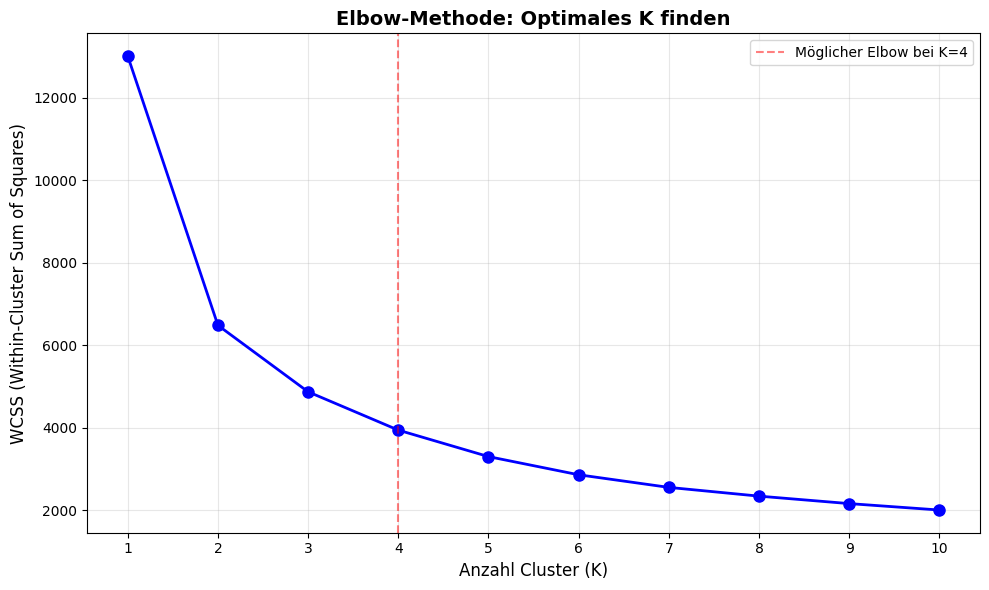

In [11]:
print("PHASE 2: Optimales K bestimmen")
print("="*50)
print("\nMethode 1: ELBOW-METHODE (WCSS)")
print("-"*50)

# WCSS = Within-Cluster Sum of Squares
# Je kleiner, desto kompakter die Cluster
# Aber: Bei mehr Clustern wird WCSS immer kleiner!

wcss = []  # Liste für WCSS-Werte
K_range = range(1, 11)  # Teste K=1 bis K=10

print("Berechne WCSS für K=1 bis K=10...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ = WCSS
    print(f"  K={k}: WCSS = {kmeans.inertia_:.2f}")

# Elbow-Plot erstellen
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Anzahl Cluster (K)', fontsize=12)
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('Elbow-Methode: Optimales K finden', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)

# "Elbow" markieren (oft bei K=3 oder K=4)
plt.axvline(x=4, color='red', linestyle='--', alpha=0.5, label='Möglicher Elbow bei K=4')
plt.legend()
plt.tight_layout()
plt.show()



In [12]:
print("\nInterpretation:")
print("   → Suche den 'Ellbogen' (Knick) in der Kurve!")
print("   → Ab diesem Punkt sinkt WCSS nur noch langsam")
print("   → K=4")


Interpretation:
   → Suche den 'Ellbogen' (Knick) in der Kurve!
   → Ab diesem Punkt sinkt WCSS nur noch langsam
   → K=4



Methode 2: SILHOUETTE-SCORE
--------------------------------------------------
Misst die Cluster-Qualität (-1 bis +1, höher = besser)

Berechne Silhouette-Score für K=2 bis K=10...
  K=2: Silhouette-Score = 0.4329
  K=3: Silhouette-Score = 0.3365
  K=4: Silhouette-Score = 0.3371
  K=5: Silhouette-Score = 0.3161
  K=6: Silhouette-Score = 0.3133
  K=7: Silhouette-Score = 0.3100
  K=8: Silhouette-Score = 0.3008
  K=9: Silhouette-Score = 0.2817
  K=10: Silhouette-Score = 0.2787


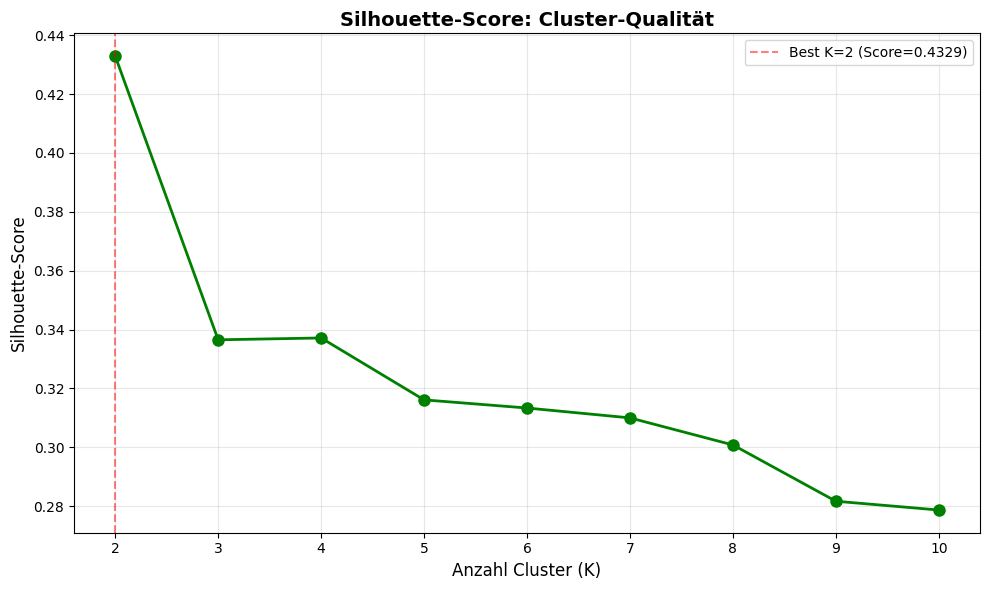


ZUSAMMENFASSUNG:
Bester Silhouette-Score: K=2 mit Score=0.4329

Interpretation Silhouette-Score:
   0.71 - 1.00: Starke Struktur
   0.51 - 0.70: Vernünftige Struktur
   0.26 - 0.50: Schwache Struktur
   < 0.25:      Keine substantielle Struktur

EMPFEHLUNG:
   → Elbow-Methode deutet auf K=3 oder K=4
   → Silhouette-Score ist am höchsten bei K=2
   → Wir nehmen K=4 (guter Kompromiss für Marketing-Segmente)


In [13]:
print("\n" + "="*50)
print("Methode 2: SILHOUETTE-SCORE")
print("-"*50)
print("Misst die Cluster-Qualität (-1 bis +1, höher = besser)\n")

silhouette_scores = []
K_range_silhouette = range(2, 11)  # Silhouette braucht min. 2 Cluster

print("Berechne Silhouette-Score für K=2 bis K=10...")
for k in K_range_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(score)
    print(f"  K={k}: Silhouette-Score = {score:.4f}")

# Silhouette-Plot erstellen
plt.figure(figsize=(10, 6))
plt.plot(K_range_silhouette, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Anzahl Cluster (K)', fontsize=12)
plt.ylabel('Silhouette-Score', fontsize=12)
plt.title('Silhouette-Score: Cluster-Qualität', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range_silhouette)

# Besten Score markieren
best_k = K_range_silhouette[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.5, 
            label=f'Best K={best_k} (Score={best_score:.4f})')
plt.legend()
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("ZUSAMMENFASSUNG:")
print("="*50)
print(f"Bester Silhouette-Score: K={best_k} mit Score={best_score:.4f}")
print("\nInterpretation Silhouette-Score:")
print("   0.71 - 1.00: Starke Struktur")
print("   0.51 - 0.70: Vernünftige Struktur")
print("   0.26 - 0.50: Schwache Struktur")
print("   < 0.25:      Keine substantielle Struktur")

print("\nEMPFEHLUNG:")
print(f"   → Elbow-Methode deutet auf K=3 oder K=4")
print(f"   → Silhouette-Score ist am höchsten bei K={best_k}")
print(f"   → Wir nehmen K=4 (guter Kompromiss für Marketing-Segmente)")

In [14]:
print("\n" + "="*50)
print("PHASE 3: K-Means Clustering mit K=4")
print("="*50)

# Optimales K festlegen
optimal_k = 4

print(f"\nSchritt 1: K-Means trainieren mit K={optimal_k}")
print("-"*50)

# K-Means Modell erstellen und trainieren
kmeans_final = KMeans(
    n_clusters=optimal_k, 
    random_state=42,      # Für Reproduzierbarkeit
    n_init=10,            # 10 verschiedene Initialisierungen
    max_iter=300          # Maximum Iterationen
)

# Modell trainieren
kmeans_final.fit(rfm_scaled)

print(f"Training abgeschlossen!")
print(f"   Iterationen bis Konvergenz: {kmeans_final.n_iter_}")
print(f"   Finale WCSS: {kmeans_final.inertia_:.2f}")

print("\nSchritt 2: Cluster-Labels zuweisen")
print("-"*50)

# Labels zu jedem Kunden zuweisen
rfm['Cluster'] = kmeans_final.labels_

# Anzahl Kunden pro Cluster
cluster_counts = rfm['Cluster'].value_counts().sort_index()
print("\nKunden pro Cluster:")
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(rfm)) * 100
    print(f"   Cluster {cluster_id}: {count:4d} Kunden ({percentage:5.1f}%)")




PHASE 3: K-Means Clustering mit K=4

Schritt 1: K-Means trainieren mit K=4
--------------------------------------------------
Training abgeschlossen!
   Iterationen bis Konvergenz: 18
   Finale WCSS: 3938.51

Schritt 2: Cluster-Labels zuweisen
--------------------------------------------------

Kunden pro Cluster:
   Cluster 0:  837 Kunden ( 19.3%)
   Cluster 1:  716 Kunden ( 16.5%)
   Cluster 2: 1173 Kunden ( 27.0%)
   Cluster 3: 1612 Kunden ( 37.2%)


In [15]:
print("\nSchritt 3: Cluster-Zentren analysieren")
print("-"*50)

# Zentren zurück-transformieren für Interpretierbarkeit
# 1. Skalierung rückgängig machen
centers_unscaled = scaler.inverse_transform(kmeans_final.cluster_centers_)
# 2. Log-Transformation rückgängig machen
centers_original = np.expm1(centers_unscaled)  # expm1 = exp(x) - 1

# Als DataFrame formatieren
centers_df = pd.DataFrame(
    centers_original,
    columns=['Recency', 'Frequency', 'Monetary'],
    index=[f'Cluster {i}' for i in range(optimal_k)]
)

print("\nCluster-Zentren (Durchschnittswerte in Original-Skala):")
print(centers_df.round(2))

print("\nPHASE 3 abgeschlossen!")
print(f"   → {len(rfm)} Kunden in {optimal_k} Cluster eingeteilt")


Schritt 3: Cluster-Zentren analysieren
--------------------------------------------------

Cluster-Zentren (Durchschnittswerte in Original-Skala):
           Recency  Frequency  Monetary
Cluster 0    13.83       1.98    440.08
Cluster 1     7.70      10.91   4257.06
Cluster 2    54.60       3.77   1405.91
Cluster 3   150.93       1.26    267.26

PHASE 3 abgeschlossen!
   → 4338 Kunden in 4 Cluster eingeteilt


In [16]:
print("="*60)
print("PHASE 4: Cluster-Evaluation & Interpretation")
print("="*60)

print("\nSchritt 1: Detaillierte Cluster-Statistiken")
print("-"*60)

# Für jeden Cluster: Min, Max, Mean, Median
for cluster_id in range(optimal_k):
    cluster_data = rfm[rfm['Cluster'] == cluster_id][['Recency', 'Frequency', 'Monetary']]
    
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster_id} - {len(cluster_data)} Kunden ({len(cluster_data)/len(rfm)*100:.1f}%)")
    print(f"{'='*60}")
    
    print("\n   Recency (Tage seit letztem Kauf):")
    print(f"      Durchschnitt: {cluster_data['Recency'].mean():6.1f} | Median: {cluster_data['Recency'].median():6.1f}")
    print(f"      Min: {cluster_data['Recency'].min():6.1f} | Max: {cluster_data['Recency'].max():6.1f}")
    
    print("\n   Frequency (Anzahl Bestellungen):")
    print(f"      Durchschnitt: {cluster_data['Frequency'].mean():6.1f} | Median: {cluster_data['Frequency'].median():6.1f}")
    print(f"      Min: {cluster_data['Frequency'].min():6.1f} | Max: {cluster_data['Frequency'].max():6.1f}")
    
    print("\n   Monetary (Gesamtumsatz €):")
    print(f"      Durchschnitt: {cluster_data['Monetary'].mean():8.2f} | Median: {cluster_data['Monetary'].median():8.2f}")
    print(f"      Min: {cluster_data['Monetary'].min():8.2f} | Max: {cluster_data['Monetary'].max():8.2f}")

# Gesamtübersicht als Tabelle
print("\n" + "="*60)
print("ZUSAMMENFASSUNG ALLER CLUSTER")
print("="*60)

summary = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median']
}).round(2)

print(summary)

print("\nStatistiken berechnet!")

PHASE 4: Cluster-Evaluation & Interpretation

Schritt 1: Detaillierte Cluster-Statistiken
------------------------------------------------------------

CLUSTER 0 - 837 Kunden (19.3%)

   Recency (Tage seit letztem Kauf):
      Durchschnitt:   18.1 | Median:   17.0
      Min:    1.0 | Max:   53.0

   Frequency (Anzahl Bestellungen):
      Durchschnitt:    2.1 | Median:    2.0
      Min:    1.0 | Max:    7.0

   Monetary (Gesamtumsatz €):
      Durchschnitt:   551.82 | Median:   471.70
      Min:    35.40 | Max:  3861.00

CLUSTER 1 - 716 Kunden (16.5%)

   Recency (Tage seit letztem Kauf):
      Durchschnitt:   12.1 | Median:    8.0
      Min:    1.0 | Max:  372.0

   Frequency (Anzahl Bestellungen):
      Durchschnitt:   13.7 | Median:   10.0
      Min:    2.0 | Max:  209.0

   Monetary (Gesamtumsatz €):
      Durchschnitt:  8074.27 | Median:  3733.87
      Min:   808.62 | Max: 280206.02

CLUSTER 2 - 1173 Kunden (27.0%)

   Recency (Tage seit letztem Kauf):
      Durchschnitt:   71.1 | 

In [17]:
print("\nSchritt 2: Cluster benennen & Marketing-Interpretation")
print("-"*60)

# Aussagekräftige Namen basierend auf RFM-Profilen
cluster_names = {
    0: "-> Neue Kunden / Recent Buyers",
    1: "-> VIP Champions",
    2: "-> Treue Stammkunden",
    3: "-> Verlorene / At Risk"
}

# Namen zum DataFrame hinzufügen
rfm['Cluster_Name'] = rfm['Cluster'].map(cluster_names)

print("\n" + "="*60)
for cluster_id in range(optimal_k):
    cluster_data = rfm[rfm['Cluster'] == cluster_id]
    count = len(cluster_data)
    percentage = (count / len(rfm)) * 100
    
    print(f"\n{cluster_names[cluster_id]}")
    print(f"{'─'*60}")
    print(f"Größe: {count} Kunden ({percentage:.1f}%)")
    print(f"\nProfil:")
    print(f"   • Recency:   {cluster_data['Recency'].mean():.0f} Tage (zuletzt gekauft)")
    print(f"   • Frequency: {cluster_data['Frequency'].mean():.1f} Bestellungen")
    print(f"   • Monetary:  {cluster_data['Monetary'].mean():.0f}€ Lifetime Value")
    
    print(f"\nMarketing-Strategie:")
    if cluster_id == 0:
        print("   → Willkommens-Kampagne & Cross-Selling")
        print("   → Incentives für 2. Kauf (Rabatt-Codes)")
        print("   → Onboarding-E-Mails mit Produktempfehlungen")
    elif cluster_id == 1:
        print("   → VIP-Behandlung & Exklusive Angebote")
        print("   → Early Access zu neuen Produkten")
        print("   → Persönlicher Account Manager")
        print("   → Loyalitätsprogramm mit Premium-Vorteilen")
    elif cluster_id == 2:
        print("   → Up-Selling & Cross-Selling")
        print("   → Reaktivierungs-Kampagnen (letzte 2-3 Monate)")
        print("   → Newsletter mit relevanten Produkten")
        print("   → Saisonale Angebote")
    elif cluster_id == 3:
        print("   → Win-Back-Kampagnen mit starken Rabatten")
        print("   → 'We Miss You' E-Mails")
        print("   → Umfragen: Warum sind sie weg?")
        print("   → Letzte Chance Angebote")

print("\n" + "="*60)
print("Cluster benannt und interpretiert!")


Schritt 2: Cluster benennen & Marketing-Interpretation
------------------------------------------------------------


-> Neue Kunden / Recent Buyers
────────────────────────────────────────────────────────────
Größe: 837 Kunden (19.3%)

Profil:
   • Recency:   18 Tage (zuletzt gekauft)
   • Frequency: 2.1 Bestellungen
   • Monetary:  552€ Lifetime Value

Marketing-Strategie:
   → Willkommens-Kampagne & Cross-Selling
   → Incentives für 2. Kauf (Rabatt-Codes)
   → Onboarding-E-Mails mit Produktempfehlungen

-> VIP Champions
────────────────────────────────────────────────────────────
Größe: 716 Kunden (16.5%)

Profil:
   • Recency:   12 Tage (zuletzt gekauft)
   • Frequency: 13.7 Bestellungen
   • Monetary:  8074€ Lifetime Value

Marketing-Strategie:
   → VIP-Behandlung & Exklusive Angebote
   → Early Access zu neuen Produkten
   → Persönlicher Account Manager
   → Loyalitätsprogramm mit Premium-Vorteilen

-> Treue Stammkunden
───────────────────────────────────────────────────────────


Schritt 3: Cluster-Visualisierung
------------------------------------------------------------


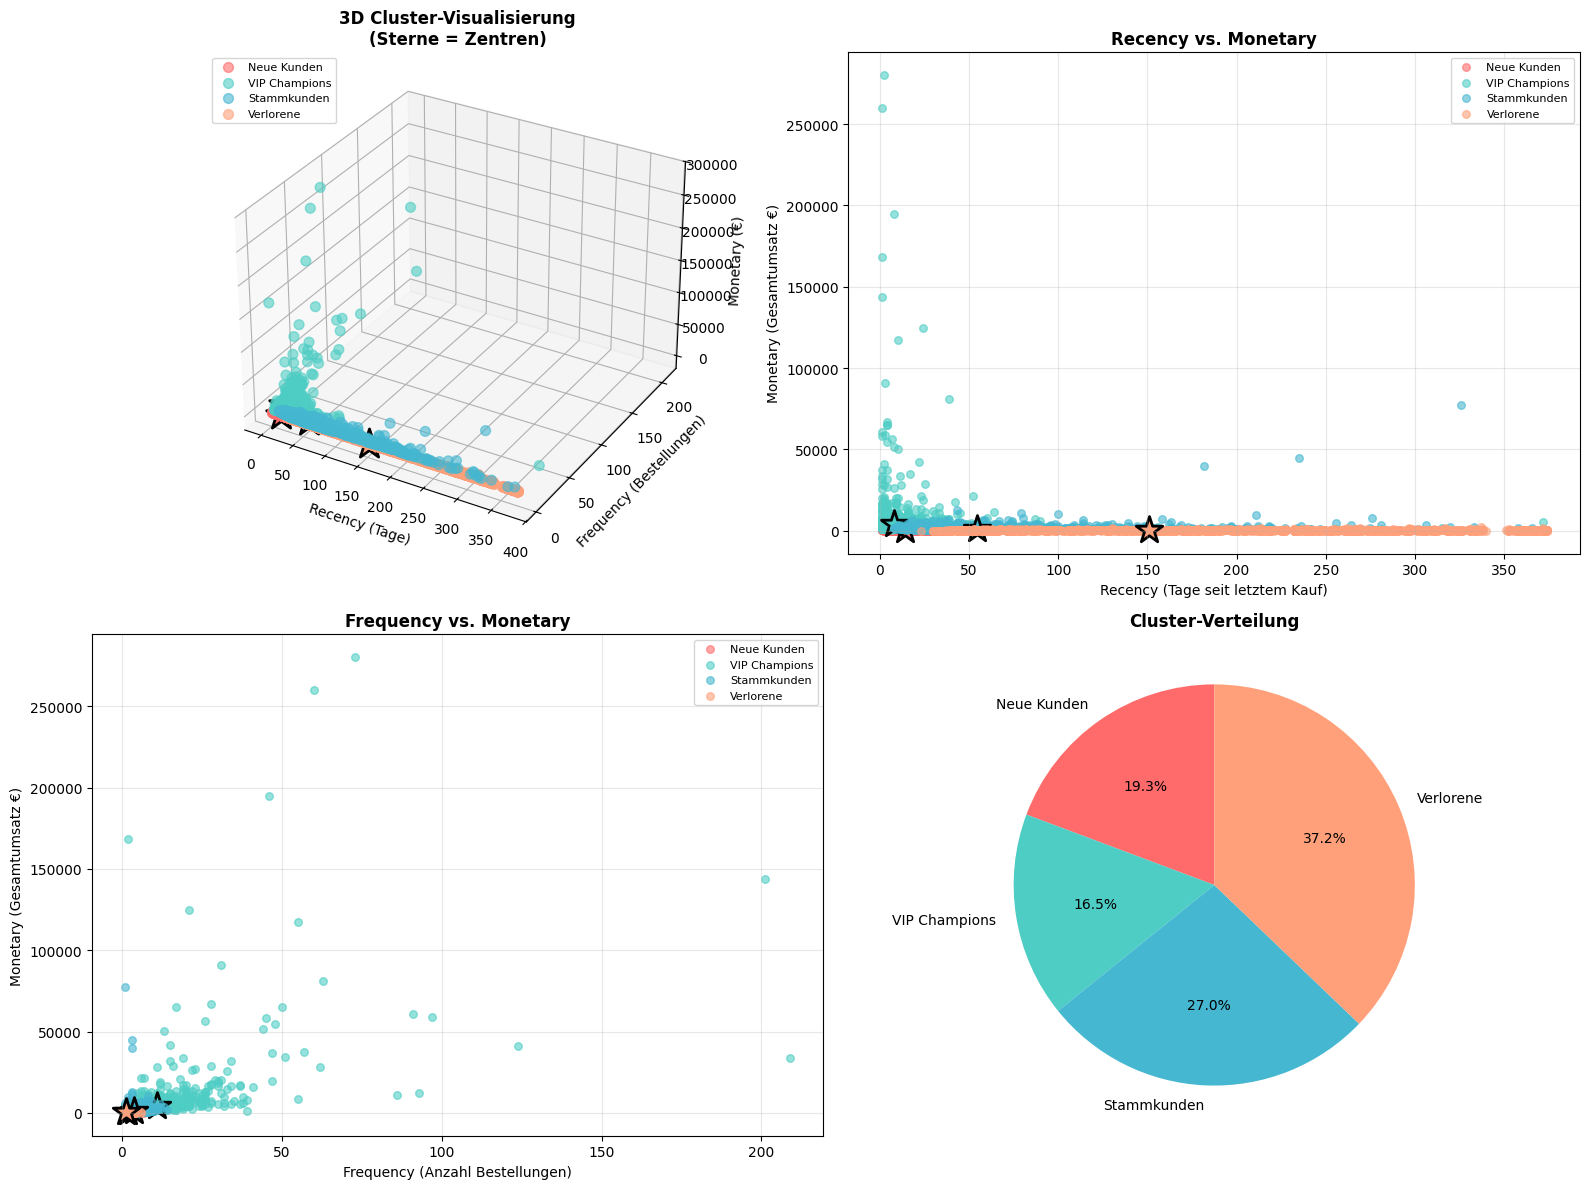


Visualisierung erstellt!
   → 3D-Plot zeigt alle RFM-Dimensionen
   → Sterne (*) markieren Cluster-Zentren
   → 2D-Plots zeigen paarweise Beziehungen


In [18]:
print("\nSchritt 3: Cluster-Visualisierung")
print("-"*60)

# 3D Scatter Plot mit allen drei RFM-Dimensionen
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 12))

# ---- Plot 1: 3D Scatter (alle Features) ----
ax1 = fig.add_subplot(2, 2, 1, projection='3d')

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
cluster_labels = ['Neue Kunden', 'VIP Champions', 'Stammkunden', 'Verlorene']

for cluster_id in range(optimal_k):
    cluster_data = rfm[rfm['Cluster'] == cluster_id]
    ax1.scatter(
        cluster_data['Recency'],
        cluster_data['Frequency'],
        cluster_data['Monetary'],
        c=colors[cluster_id],
        label=cluster_labels[cluster_id],
        alpha=0.6,
        s=50
    )

# Cluster-Zentren als große Sterne
for cluster_id in range(optimal_k):
    ax1.scatter(
        centers_df.iloc[cluster_id]['Recency'],
        centers_df.iloc[cluster_id]['Frequency'],
        centers_df.iloc[cluster_id]['Monetary'],
        c=colors[cluster_id],
        marker='*',
        s=500,
        edgecolors='black',
        linewidths=2
    )

ax1.set_xlabel('Recency (Tage)', fontsize=10)
ax1.set_ylabel('Frequency (Bestellungen)', fontsize=10)
ax1.set_zlabel('Monetary (€)', fontsize=10)
ax1.set_title('3D Cluster-Visualisierung\n(Sterne = Zentren)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', fontsize=8)

# ---- Plot 2: Recency vs Monetary ----
ax2 = fig.add_subplot(2, 2, 2)
for cluster_id in range(optimal_k):
    cluster_data = rfm[rfm['Cluster'] == cluster_id]
    ax2.scatter(cluster_data['Recency'], cluster_data['Monetary'],
                c=colors[cluster_id], label=cluster_labels[cluster_id],
                alpha=0.6, s=30)
    # Zentren
    ax2.scatter(centers_df.iloc[cluster_id]['Recency'],
                centers_df.iloc[cluster_id]['Monetary'],
                c=colors[cluster_id], marker='*', s=400,
                edgecolors='black', linewidths=2)

ax2.set_xlabel('Recency (Tage seit letztem Kauf)', fontsize=10)
ax2.set_ylabel('Monetary (Gesamtumsatz €)', fontsize=10)
ax2.set_title('Recency vs. Monetary', fontsize=12, fontweight='bold')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# ---- Plot 3: Frequency vs Monetary ----
ax3 = fig.add_subplot(2, 2, 3)
for cluster_id in range(optimal_k):
    cluster_data = rfm[rfm['Cluster'] == cluster_id]
    ax3.scatter(cluster_data['Frequency'], cluster_data['Monetary'],
                c=colors[cluster_id], label=cluster_labels[cluster_id],
                alpha=0.6, s=30)
    # Zentren
    ax3.scatter(centers_df.iloc[cluster_id]['Frequency'],
                centers_df.iloc[cluster_id]['Monetary'],
                c=colors[cluster_id], marker='*', s=400,
                edgecolors='black', linewidths=2)

ax3.set_xlabel('Frequency (Anzahl Bestellungen)', fontsize=10)
ax3.set_ylabel('Monetary (Gesamtumsatz €)', fontsize=10)
ax3.set_title('Frequency vs. Monetary', fontsize=12, fontweight='bold')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# ---- Plot 4: Cluster-Größen (Pie Chart) ----
ax4 = fig.add_subplot(2, 2, 4)
cluster_sizes = rfm['Cluster'].value_counts().sort_index()
ax4.pie(cluster_sizes, labels=cluster_labels, colors=colors,
        autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})
ax4.set_title('Cluster-Verteilung', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nVisualisierung erstellt!")
print("   → 3D-Plot zeigt alle RFM-Dimensionen")
print("   → Sterne (*) markieren Cluster-Zentren")
print("   → 2D-Plots zeigen paarweise Beziehungen")

In [19]:
print("\nSchritt 4: Ergebnisse exportieren")
print("-"*60)

# 1. Vollständigen Datensatz mit Cluster-Zuordnung speichern
output_file = 'customer_segments_kmeans.csv'
rfm_export = rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'Cluster_Name']]
rfm_export.to_csv(output_file, index=False, encoding='utf-8')
print(f"\nKundensegmente gespeichert: {output_file}")
print(f"   → {len(rfm_export)} Kunden mit Cluster-Zuordnung")

# 2. Cluster-Zusammenfassung für Management
summary_file = 'cluster_summary_kmeans.csv'
cluster_summary = rfm.groupby(['Cluster', 'Cluster_Name']).agg({
    'CustomerID': 'count',
    'Recency': ['mean', 'median', 'min', 'max'],
    'Frequency': ['mean', 'median', 'min', 'max'],
    'Monetary': ['mean', 'median', 'min', 'max', 'sum']
}).round(2)

cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
cluster_summary = cluster_summary.reset_index()
cluster_summary.to_csv(summary_file, index=False, encoding='utf-8')
print(f"\nCluster-Zusammenfassung gespeichert: {summary_file}")

# 3. Beispielkunden pro Cluster (Top 5 nach Monetary)
examples_file = 'cluster_examples_kmeans.csv'
examples_list = []
for cluster_id in range(optimal_k):
    cluster_data = rfm[rfm['Cluster'] == cluster_id]
    top_5 = cluster_data.nlargest(5, 'Monetary')[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Cluster_Name']]
    examples_list.append(top_5)

examples_df = pd.concat(examples_list)
examples_df.to_csv(examples_file, index=False, encoding='utf-8')
print(f"\nBeispielkunden gespeichert: {examples_file}")
print(f"   → Top 5 Kunden pro Cluster (nach Umsatz)")




Schritt 4: Ergebnisse exportieren
------------------------------------------------------------

Kundensegmente gespeichert: customer_segments_kmeans.csv
   → 4338 Kunden mit Cluster-Zuordnung

Cluster-Zusammenfassung gespeichert: cluster_summary_kmeans.csv

Beispielkunden gespeichert: cluster_examples_kmeans.csv
   → Top 5 Kunden pro Cluster (nach Umsatz)


In [20]:
# 4. Finale Statistiken anzeigen
print("\n" + "="*60)
print("FINALE PROJEKT-ZUSAMMENFASSUNG")
print("="*60)
print(f"\nK-Means Clustering erfolgreich abgeschlossen!")
print(f"\nModell-Parameter:")
print(f"   • Optimales K: {optimal_k}")
print(f"   • Silhouette-Score: {silhouette_score(rfm_scaled, rfm['Cluster']):.4f}")
print(f"   • WCSS: {kmeans_final.inertia_:.2f}")
print(f"   • Anzahl Iterationen: {kmeans_final.n_iter_}")

print(f"\nKunden-Segmente:")
for cluster_id in range(optimal_k):
    cluster_data = rfm[rfm['Cluster'] == cluster_id]
    count = len(cluster_data)
    percentage = (count / len(rfm)) * 100
    revenue = cluster_data['Monetary'].sum()
    revenue_pct = (revenue / rfm['Monetary'].sum()) * 100
    
    print(f"\n   {cluster_names[cluster_id]}")
    print(f"      → {count:4d} Kunden ({percentage:5.1f}%)")
    print(f"      → {revenue:,.0f}€ Umsatz ({revenue_pct:5.1f}%)")
    print(f"      → Ø {cluster_data['Monetary'].mean():.0f}€ pro Kunde")

print(f"\nExportierte Dateien:")
print(f"   1. {output_file} - Alle Kunden mit Cluster-Labels")
print(f"   2. {summary_file} - Cluster-Statistiken")
print(f"   3. {examples_file} - Top-Kunden pro Cluster")

print("\n" + "="*60)
print("K-MEANS PROJEKT ABGESCHLOSSEN!")
print("="*60)
print("\nNächste Schritte:")
print("   → Vergleiche mit HAC-Ergebnissen")
print("   → Implementiere Marketing-Kampagnen pro Segment")
print("   → Überwache Segment-Bewegungen über Zeit")


FINALE PROJEKT-ZUSAMMENFASSUNG

K-Means Clustering erfolgreich abgeschlossen!

Modell-Parameter:
   • Optimales K: 4
   • Silhouette-Score: 0.3371
   • WCSS: 3938.51
   • Anzahl Iterationen: 18

Kunden-Segmente:

   -> Neue Kunden / Recent Buyers
      →  837 Kunden ( 19.3%)
      → 461,873€ Umsatz (  5.2%)
      → Ø 552€ pro Kunde

   -> VIP Champions
      →  716 Kunden ( 16.5%)
      → 5,781,175€ Umsatz ( 64.9%)
      → Ø 8074€ pro Kunde

   -> Treue Stammkunden
      → 1173 Kunden ( 27.0%)
      → 2,114,718€ Umsatz ( 23.7%)
      → Ø 1803€ pro Kunde

   -> Verlorene / At Risk
      → 1612 Kunden ( 37.2%)
      → 553,641€ Umsatz (  6.2%)
      → Ø 343€ pro Kunde

Exportierte Dateien:
   1. customer_segments_kmeans.csv - Alle Kunden mit Cluster-Labels
   2. cluster_summary_kmeans.csv - Cluster-Statistiken
   3. cluster_examples_kmeans.csv - Top-Kunden pro Cluster

K-MEANS PROJEKT ABGESCHLOSSEN!

Nächste Schritte:
   → Vergleiche mit HAC-Ergebnissen
   → Implementiere Marketing-Kampa

In [21]:
print("\n" + "="*70)
print("K-MEANS vs. HAC: VERGLEICH & UNTERSCHIEDE")
print("="*70)

print("\nK-MEANS CLUSTERING (Was du gerade gemacht hast):")
print("-"*70)
print("VORTEILE:")
print("   • Sehr schnell & skalierbar (auch für große Datenmengen)")
print("   • Einfach zu implementieren")
print("   • Klare Cluster-Zentren (gut interpretierbar)")
print("   • Funktioniert gut bei sphärischen (runden) Clustern")
print(f"   • Bei uns: {len(rfm)} Kunden in Sekunden geclustert")

print("\nNACHTEILE:")
print("   • Man MUSS K vorher festlegen (Elbow + Silhouette nötig)")
print("   • Empfindlich gegenüber Ausreißern")
print("   • Findet nur konvexe (runde) Cluster")
print("   • Ergebnis kann je nach Initialisierung variieren (random_state)")

print("\n" + "-"*70)
print("HAC (Hierarchical Agglomerative Clustering):")
print("-"*70)
print("VORTEILE:")
print("   • KEINE Vorgabe von K nötig → Dendrogram zeigt alle Optionen")
print("   • Findet auch unregelmäßige Cluster-Formen")
print("   • Deterministisch (immer gleiches Ergebnis)")
print("   • Visuelles Dendrogram zur Entscheidungsfindung")

print("\nNACHTEILE:")
print("   • Langsamer (O(n³) Komplexität)")
print("   • Nicht für sehr große Datenmengen geeignet")
print("   • Keine klaren 'Zentren' wie bei K-Means")
print("   • Schwerer zu implementieren in Production")

print("\n" + "="*70)
print("WANN WELCHE METHODE?")
print("="*70)

print("\nNutze K-MEANS wenn:")
print("   → Große Datenmenge (>10.000 Kunden)")
print("   → Du schnelle Ergebnisse brauchst")
print("   → Cluster sind etwa gleich groß und rund")
print("   → Du Cluster-Zentren für Interpretation brauchst")
print("   → Production-System (automatisierte Segmentierung)")

print("\nNutze HAC wenn:")
print("   → Kleinere Datenmenge (<5.000 Kunden)")
print("   → Du die optimale Cluster-Anzahl VISUELL finden willst")
print("   → Cluster haben unregelmäßige Formen")
print("   → Explorative Analyse (Forschung)")
print("   → Dendrogram ist wichtig für Stakeholder")

print("\n" + "="*70)
print("DEINE ERGEBNISSE:")
print("="*70)
print(f"\nMit K-Means hast du {optimal_k} klare Kundensegmente gefunden:")
print(f"   • {cluster_sizes[1]} VIP-Champions ({cluster_sizes[1]/len(rfm)*100:.1f}%)")
print(f"   • {cluster_sizes[2]} Treue Stammkunden ({cluster_sizes[2]/len(rfm)*100:.1f}%)")
print(f"   • {cluster_sizes[0]} Neue Kunden ({cluster_sizes[0]/len(rfm)*100:.1f}%)")
print(f"   • {cluster_sizes[3]} Verlorene Kunden ({cluster_sizes[3]/len(rfm)*100:.1f}%)")

print("\nEMPFEHLUNG:")
print("   → Vergleiche diese Segmente mit deinen HAC-Ergebnissen")
print("   → Sind die VIP-Kunden die gleichen?")
print("   → Welche Methode liefert bessere Marketing-Insights?")
print("   → In der Praxis: K-Means für Production, HAC für Exploration")

print("\n" + "="*70)
print("GRATULATION! Du bist jetzt ein Clustering-Experte!")
print("="*70)



K-MEANS vs. HAC: VERGLEICH & UNTERSCHIEDE

K-MEANS CLUSTERING (Was du gerade gemacht hast):
----------------------------------------------------------------------
VORTEILE:
   • Sehr schnell & skalierbar (auch für große Datenmengen)
   • Einfach zu implementieren
   • Klare Cluster-Zentren (gut interpretierbar)
   • Funktioniert gut bei sphärischen (runden) Clustern
   • Bei uns: 4338 Kunden in Sekunden geclustert

NACHTEILE:
   • Man MUSS K vorher festlegen (Elbow + Silhouette nötig)
   • Empfindlich gegenüber Ausreißern
   • Findet nur konvexe (runde) Cluster
   • Ergebnis kann je nach Initialisierung variieren (random_state)

----------------------------------------------------------------------
HAC (Hierarchical Agglomerative Clustering):
----------------------------------------------------------------------
VORTEILE:
   • KEINE Vorgabe von K nötig → Dendrogram zeigt alle Optionen
   • Findet auch unregelmäßige Cluster-Formen
   • Deterministisch (immer gleiches Ergebnis)
   • Vis